In [1]:
import sys
import os
from sciviso import *
from scproximite import *

# Set-up

### Visualisation Aesthetics

In [2]:
#Set directory to save figures to:
figure_dir = ''

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 300

# Set to true if you want to save figures out:
save = False

#Seaborn theme and context:
sns.set_context("notebook")
sns.set_style("darkgrid",{'ytick.left': True,'xtick.bottom': True, 'axes.linewidth':1, 'axes.edgecolor':'black'})


#Colour dictionary for Metrics:
colour_dict = {'euclidean':'#393b79', 'cityblock':'#6b6ecf', 'correlation':'#637939', 'spearman':'#b5cf6b', 'cosine':'#e6550d',
          'braycurtis':'#843c39', 'hamming':'#d6616b', 'jaccard':'#31a354', 'kulsinski':'#7b4173', 'yule':'#ce6dbd',
          'OT':'#e7ba52', 'phi_s':'#3182bd','weighted_rank':'#e7969c', 'kendall':'#fdae6b', 'zi_kendall':'#9467bd',
          'canberra':'#8c6d31', 'chebyshev':'#636363'}

colour_pal = ['#1b9e77', '#d95f02','#7570b3','#e7298a']

### Load data and create visualisation Dataframe

In [4]:
data_dir = '../results/'

all_datasets = ['Discrete_Abundant_Base_Simulation','Discrete_Abundant_70%_Simulation','Discrete_Abundant_90%_Simulation',
                'Discrete_ModeratelyRare_Base_Simulation','Discrete_ModeratelyRare_70%_Simulation','Discrete_ModeratelyRare_90%_Simulation',
                'Continuous_Abundant_Base_Simulation','Continuous_Abundant_70%_Simulation','Continuous_Abundant_90%_Simulation',
                'Continuous_ModeratelyRare_Base_Simulation','Continuous_ModeratelyRare_70%_Simulation','Continuous_ModeratelyRare_90%_Simulation']

datasets = dict.fromkeys(all_datasets, None) 

In [5]:
# Define the metrics, k values and evaluation scores to load in:
all_metrics = ['euclidean', 'cityblock', 'correlation', 'spearman', 'cosine', 'braycurtis', 'hamming', 'jaccard',
            'kulsinski', 'yule', 'OT', 'phi_s', 'weighted_rank', 'kendall', 'zi_kendall','canberra', 'chebyshev']

eval_metrics=['PSI']

k_vals = ["3K_stats", '10K_stats', "30K_stats", "50K_stats"]

for dataset in datasets.keys():
    datasets[dataset] = load_pickle(dataset, data_dir, mode='mean', metrics= all_metrics,eval_metrics=eval_metrics,k_vals=k_vals)

In [6]:
vis_df = vis_dataframe(datasets=all_datasets, datasets_dict=datasets, metrics=all_metrics, k_vals=k_vals, eval_metrics=eval_metrics)

In [7]:
#Get the mean PSI for each metric, grouped by dataset across all k values:
mean_df = vis_df.groupby(['Metric','Dataset'])['Performance'].describe()
mean_df['ID'] = mean_df.index.map(lambda x: '_'.join([str(i) for i in x]))
dat = mean_df.reset_index()
dat = dat[['mean', 'ID']]

vis_df['ID'] = vis_df['Metric'].str.cat(vis_df[['Dataset']], sep='_')

In [8]:
delta_df = vis_df.merge(dat, how='inner', on='ID')
delta_df = delta_df.drop(labels = ['Performance','k_value','Evaluation_Metric',
                                 'Population_Balance','ID'], axis = 1)
delta_df = delta_df.drop_duplicates(keep='first')

In [9]:
#Get difference between a metrics PSI for a dataset at low (Base) and moderate (70%) sparsity:
for index, row in delta_df.iterrows():
        met = row['Metric']
        con = row['Condition']
        Base = delta_df.query(f"Metric == '{met}' and Property=='Base' and Condition=='{con}'")
        P70 = delta_df.query(f"Metric == '{met}' and Property=='70%' and Condition=='{con}'")
        P90 = delta_df.query(f"Metric == '{met}' and Property=='90%' and Condition=='{con}'")
        delta_df.loc[index,'S1'] = Base['mean'].values - P70['mean'].values

In [12]:
import warnings
# Ignore setting with copy warning
warnings.simplefilter(action='ignore')

#Split dataframe by structural condition (e.g. Discrete Abundant)
adatas = [delta_df[delta_df['Condition'].isin([conditions])] for conditions in delta_df['Condition'].unique()]

#Score datasets within structural condition based on the direction and magnitude of change:
for dat in adatas:
    threshold = dat['S1'].describe() #Set threshold as the 75% quantile of maximum scores.
    for index, row in dat.iterrows():
        if row['S1'] < -0.05:
            dat.loc[index,'Score']  = '+'
        elif row['S1'] > 0.05 and row['S1'] < threshold['75%']: 
            dat.loc[index,'Score']  = '-'
        elif row['S1'] >= threshold['75%']:
            dat.loc[index,'Score']  = 'V-'
        else:
            dat.loc[index,'Score']  = 'R'
            
scored_data = pd.concat(adatas)

In [13]:
scored_data['Condition'] = pd.Categorical(scored_data['Condition'], categories=['Discrete Abundant','Discrete ModeratelyRare', 'Continuous Abundant', 'Continuous ModeratelyRare'], ordered=True)
scored_data = scored_data.sort_values(['Metric','Condition']).reset_index(drop=True)

# Figure 7

### Robust Metrics:

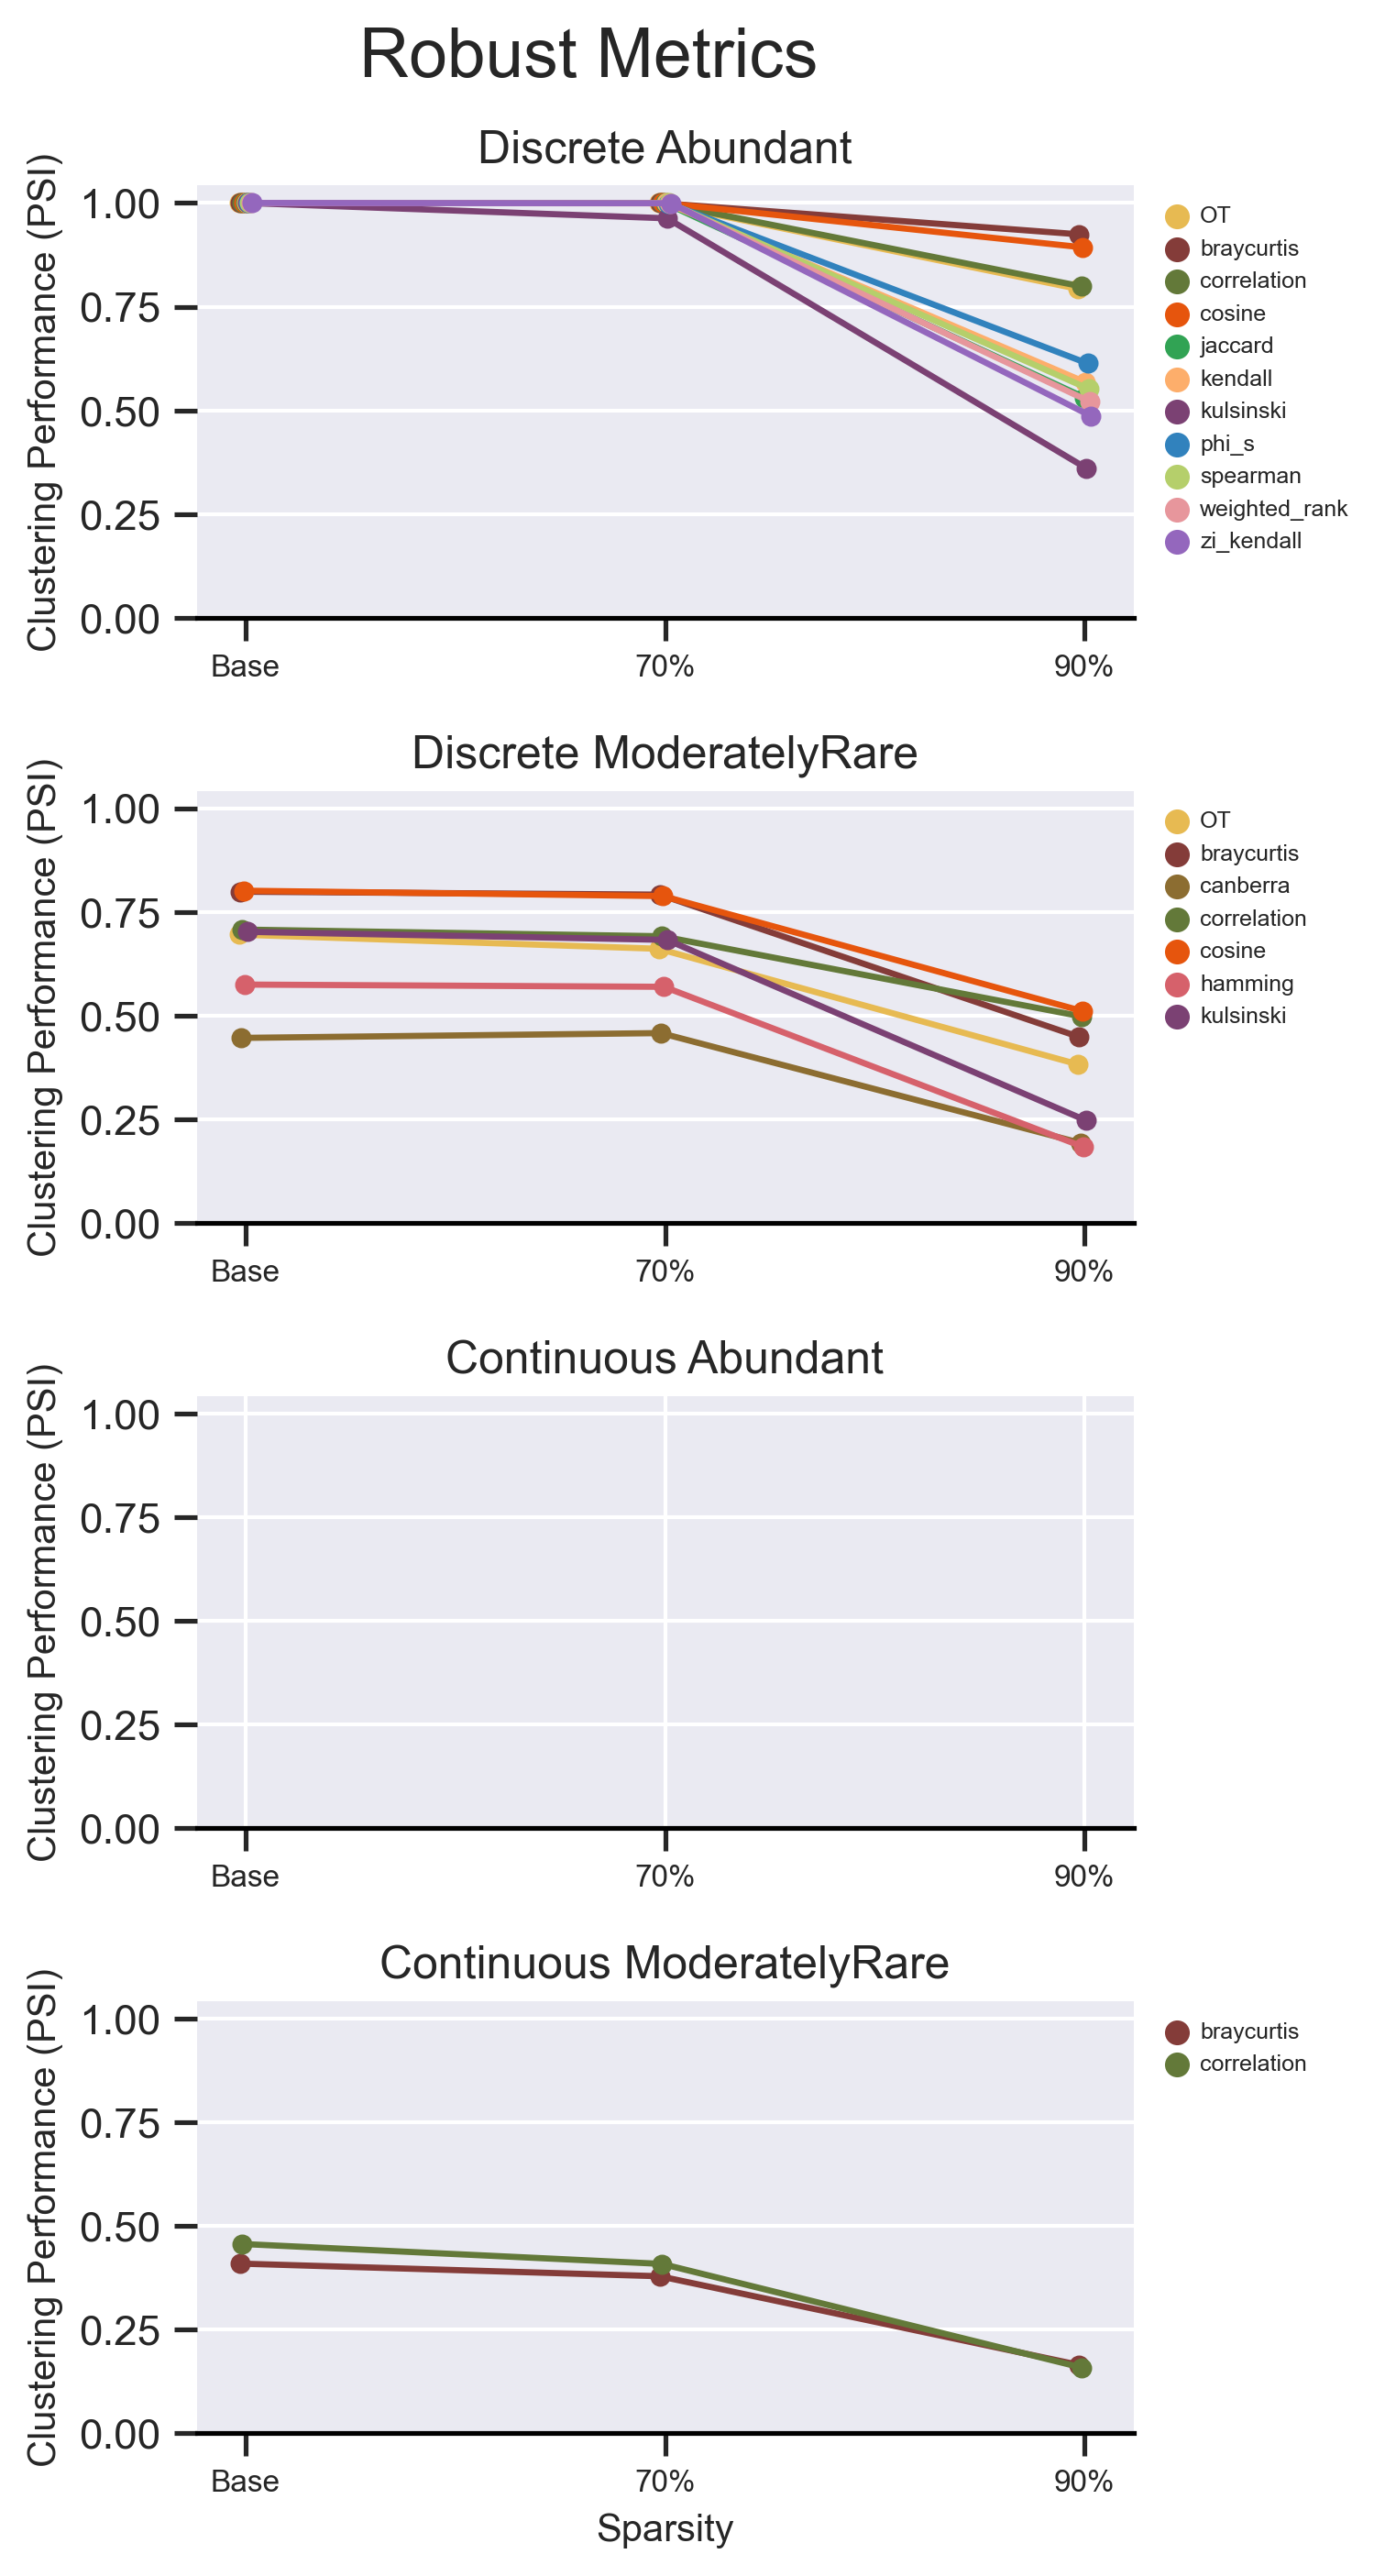

In [14]:
data = scored_data[scored_data['Score'].isin(['R'])]

g = sns.catplot(x = 'Property',                  
                y = "mean", 
                data = data,
                hue = 'Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete ModeratelyRare', 'Continuous Abundant', 'Continuous ModeratelyRare'],
                col_wrap = 1,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base','70%','90%'],
                dodge=0.03,
                aspect = 1.8,
                sharey = True,
                height = 2.4,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)


#### To produce individual legends for each subplot: ######
# MASTER SERIES OF serial
ser_vals = pd.Series(data['Metric'].sort_values().unique())

for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()
    
    #aesthetics for axes subplots:
    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    
    # SUBSET MASTER SERIES OF serial
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()

    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(), loc=2,
                    bbox_to_anchor=(1, 1),prop={'size': 6}, markerscale=1.3,
                    facecolor='white',handletextpad=0, frameon=False)
################################################################
        
g.fig.subplots_adjust(top=0.92, wspace=0.1,hspace=0.4)

g.set_titles(template='{col_name}')
g.set_ylabels('Clustering Performance (PSI)',fontsize=10)
g.set_xlabels('Sparsity', fontsize=10)
g.set_xticklabels(fontsize=8)
g.set(ylim=(0, None))

g.fig.suptitle(f'Robust Metrics',fontsize=18)

if save is True:
    plt.savefig(f'{fig_dir}Figure_7_Robust.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_7_Robust.png',  bbox_inches = 'tight')

### Sensitive Metrics:

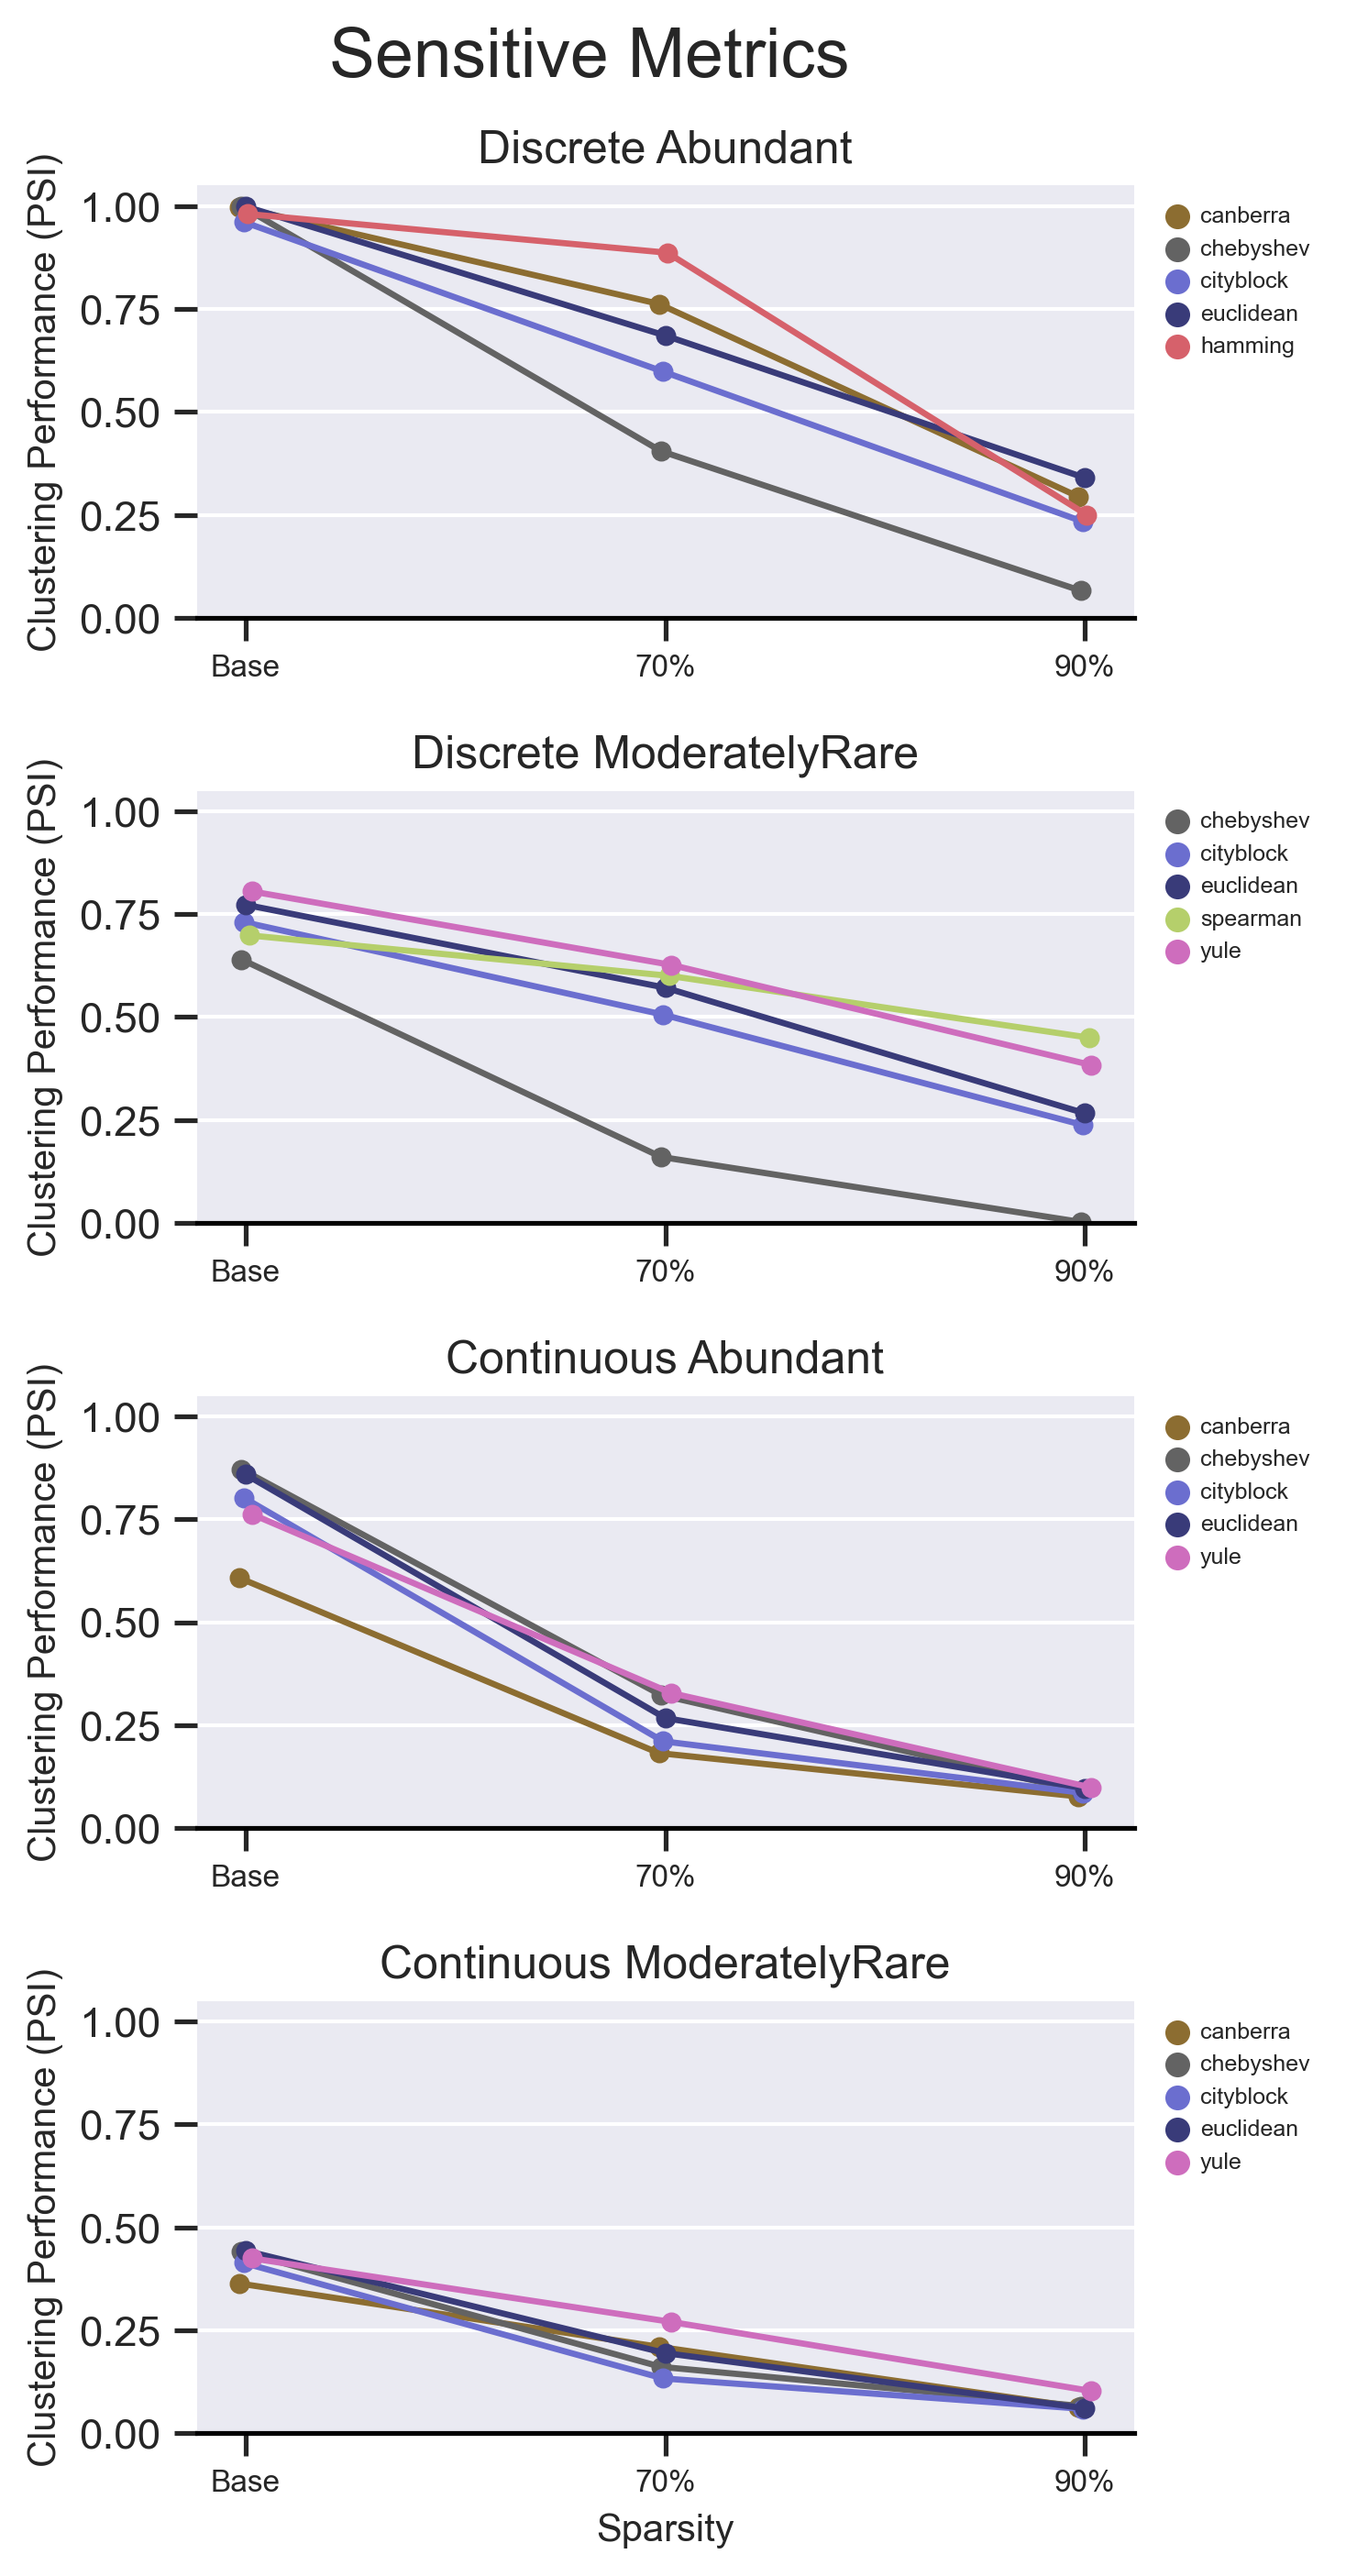

In [15]:
data = scored_data[scored_data['Score'].isin(['V-'])]

g = sns.catplot(x = "Property",                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete ModeratelyRare', 'Continuous Abundant', 'Continuous ModeratelyRare'],
                col_wrap = 1,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base','70%','90%'],
                dodge=0.03,
                aspect = 1.8,
                sharey = True,
                height = 2.4,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)


ser_vals = pd.Series(data['Metric'].sort_values().unique())
for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()
    
    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)

    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()
    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(), loc=2,
                    bbox_to_anchor=(1, 1),prop={'size': 6}, markerscale=1.3,
                    facecolor='white',handletextpad=0,frameon=False)
        
g.fig.subplots_adjust(top=0.92, wspace=0.1,hspace=0.4)

g.set_titles(template='{col_name}')
g.set_ylabels('Clustering Performance (PSI)',fontsize=10)
g.set(ylim=(0, None))
g.set_xlabels('Sparsity', fontsize=10)
g.set_xticklabels(fontsize=8)

g.fig.suptitle(f'Sensitive Metrics',fontsize=18)

if save is True:
    plt.savefig(f'{fig_dir}Figure_7_Sensitive.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_7_Sensitive.png',  bbox_inches = 'tight')

# Supplementary Figure 8

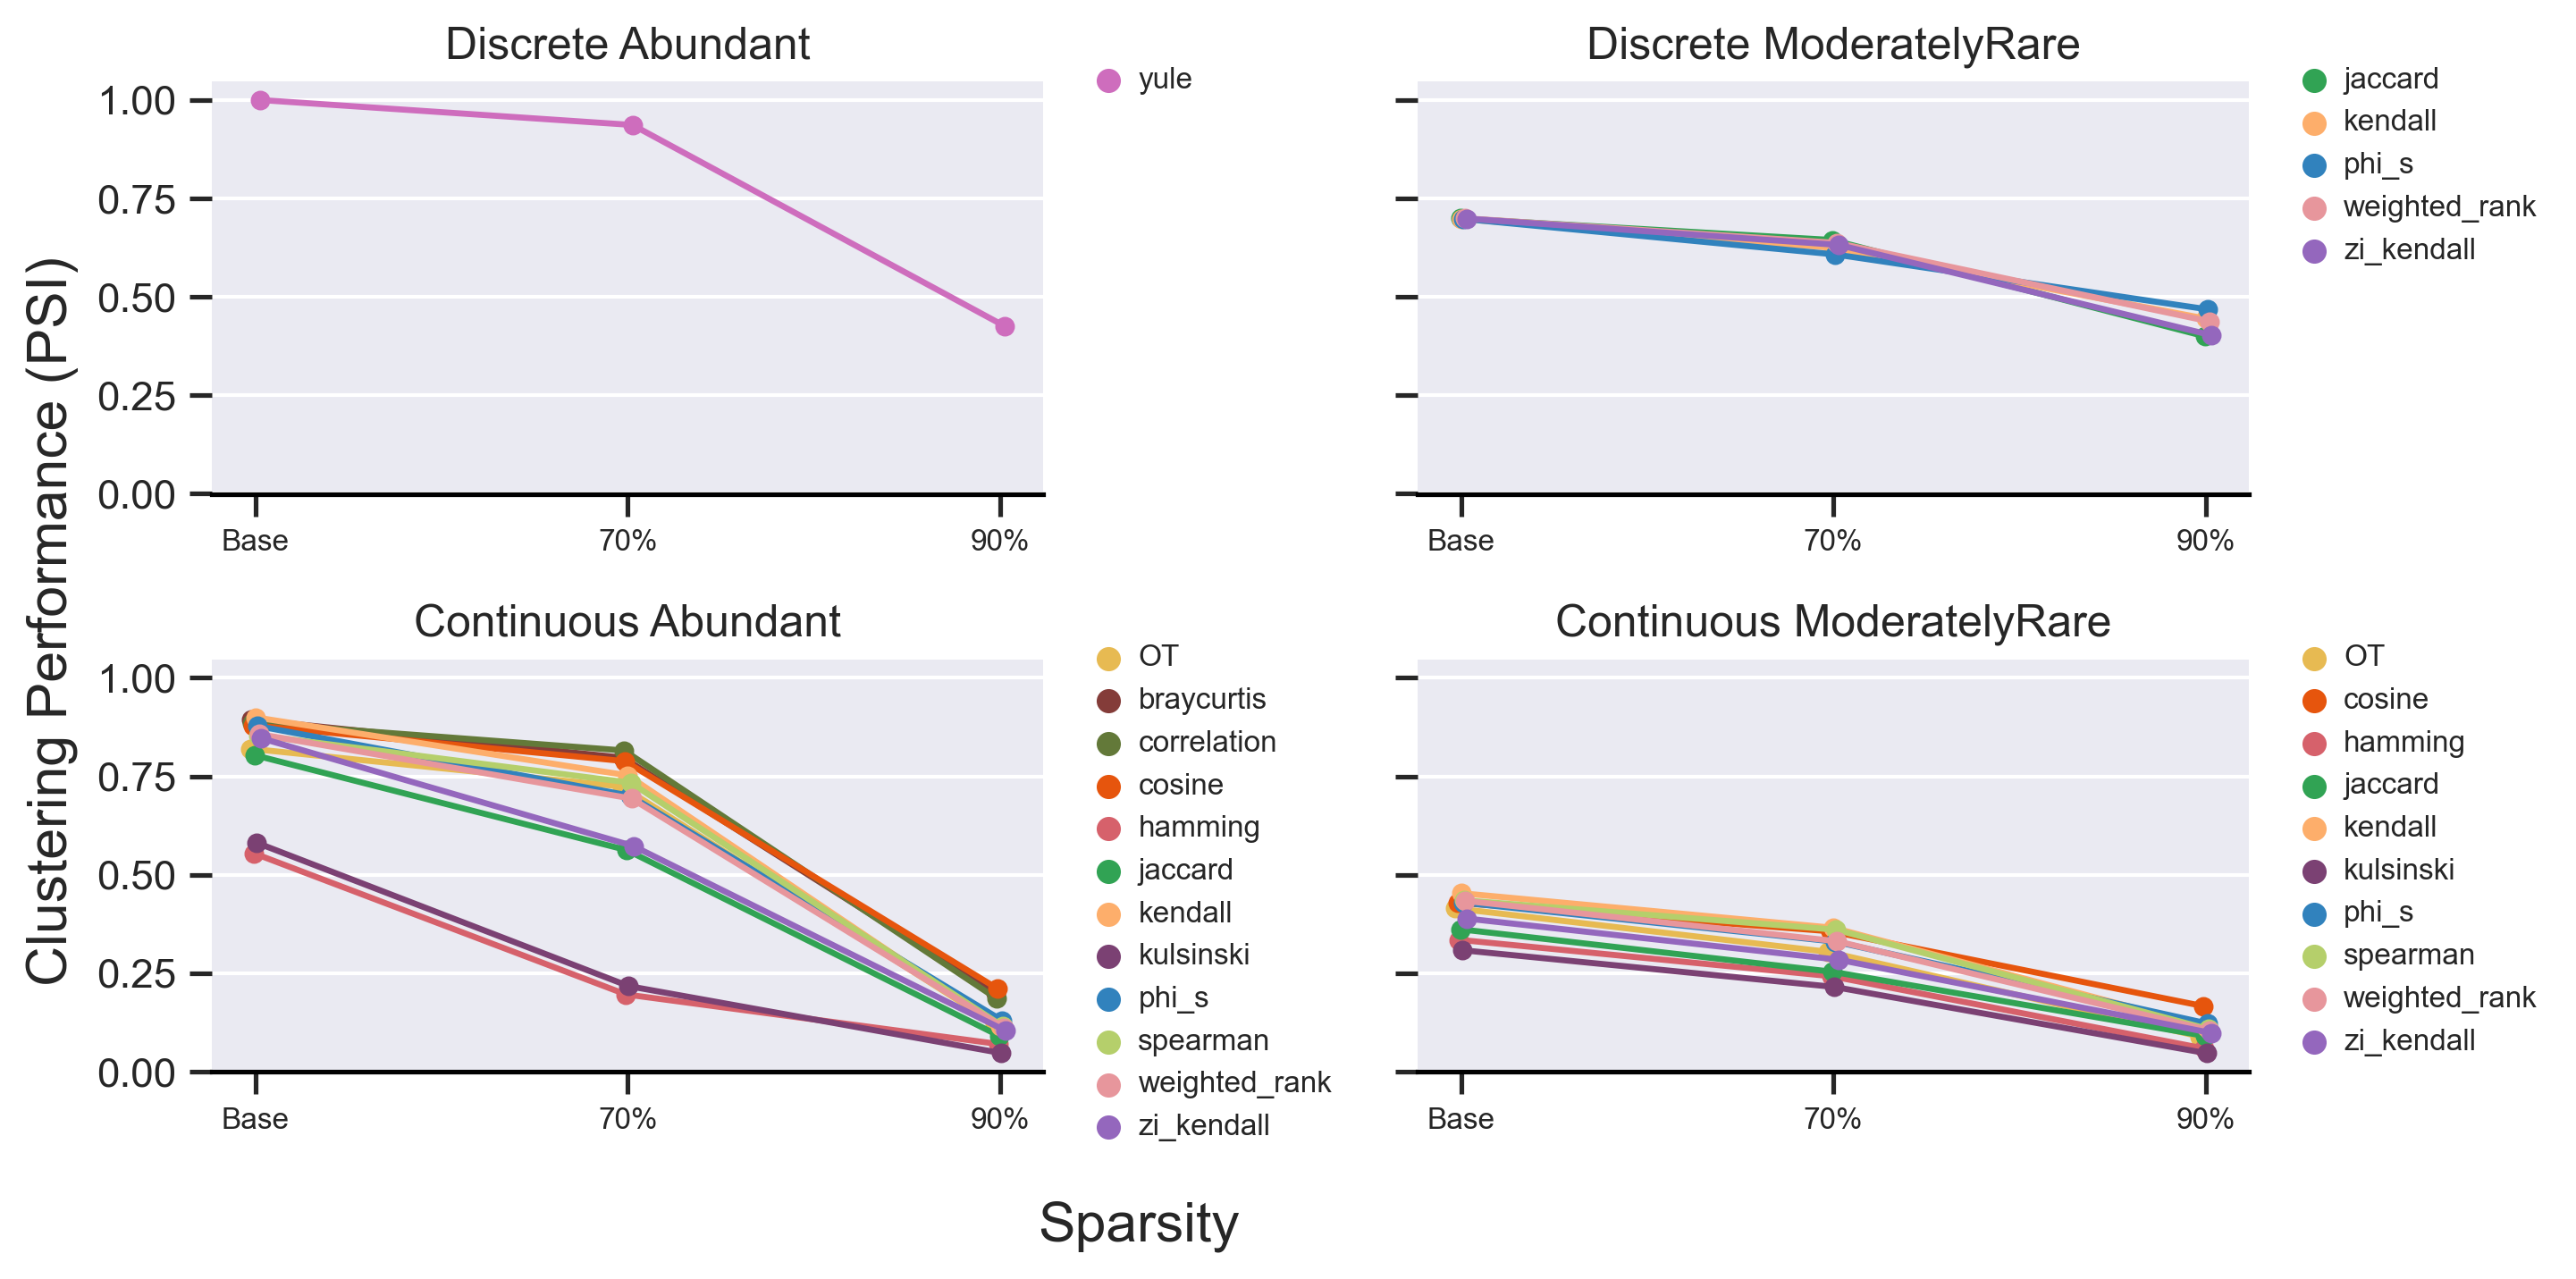

In [16]:
data = scored_data[scored_data['Score'].isin(['-'])]

g = sns.catplot(x = "Property",                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete ModeratelyRare', 'Continuous Abundant', 'Continuous ModeratelyRare'],
                col_wrap = 2,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base','70%','90%'],
                dodge=0.03,
                aspect = 1.8,
                sharey = True,
                height = 2.4,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)

ser_vals = pd.Series(data['Metric'].sort_values().unique())
for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()

    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()
    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(), loc=2,
                    bbox_to_anchor=(1.01, 1.1),prop={'size': 8}, markerscale=1.3,
                    facecolor='white',handletextpad=0,frameon=False)

g.fig.subplots_adjust(left=0.1, bottom=0.15,wspace=0.45,hspace=0.4)
g.set(ylim=(None, None))

g.set_ylabels('')
g.set_xlabels(' ')
g.set_xticklabels(fontsize=8)
g.set_titles(template='{col_name}')

g.fig.supxlabel('Sparsity',fontsize=15)
g.fig.supylabel('Clustering Performance (PSI)', fontsize=15)

if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup8.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_Sup8.png',  bbox_inches = 'tight', dpi=300)

# Supplementary Figure 9

In [17]:
#sort by change in PSI between low (Base) and moderate (70%) sparsity
adatas[0] = adatas[0].sort_values(by=['S1'], ascending=True)
adatas[0].reset_index(drop=True,inplace=True)
adatas[0]['S1_rank'] = adatas[0].index 
adatas[0] = adatas[0][adatas[0]['S1'] <= 0.0] #filter Discrete Abundant condition to only retain metrics with no change due to how many there are.

In [18]:
#filter remaining conditions to only retain the metrics with least reduction in PSI from low to moderate sparsity
new_dfs = []
for data in [adatas[1],adatas[2],adatas[3]]:
    data = data.sort_values(by=['S1'], ascending=True)
    data.reset_index(drop=True,inplace=True)
    data['S1_rank'] = data.index 
    data = data[:15]
    new_dfs.append(data)
    
adatas[1],adatas[2],adatas[3] = new_dfs

In [19]:
filtered_data = pd.concat(adatas)

#Sort for subplot legends:
filtered_data['Condition'] = pd.Categorical(filtered_data['Condition'], categories=['Discrete Abundant','Discrete ModeratelyRare',
                                                                                    'Continuous Abundant', 'Continuous ModeratelyRare'], ordered=True)
filtered_data = filtered_data.sort_values(['Metric','Condition']).reset_index(drop=True)

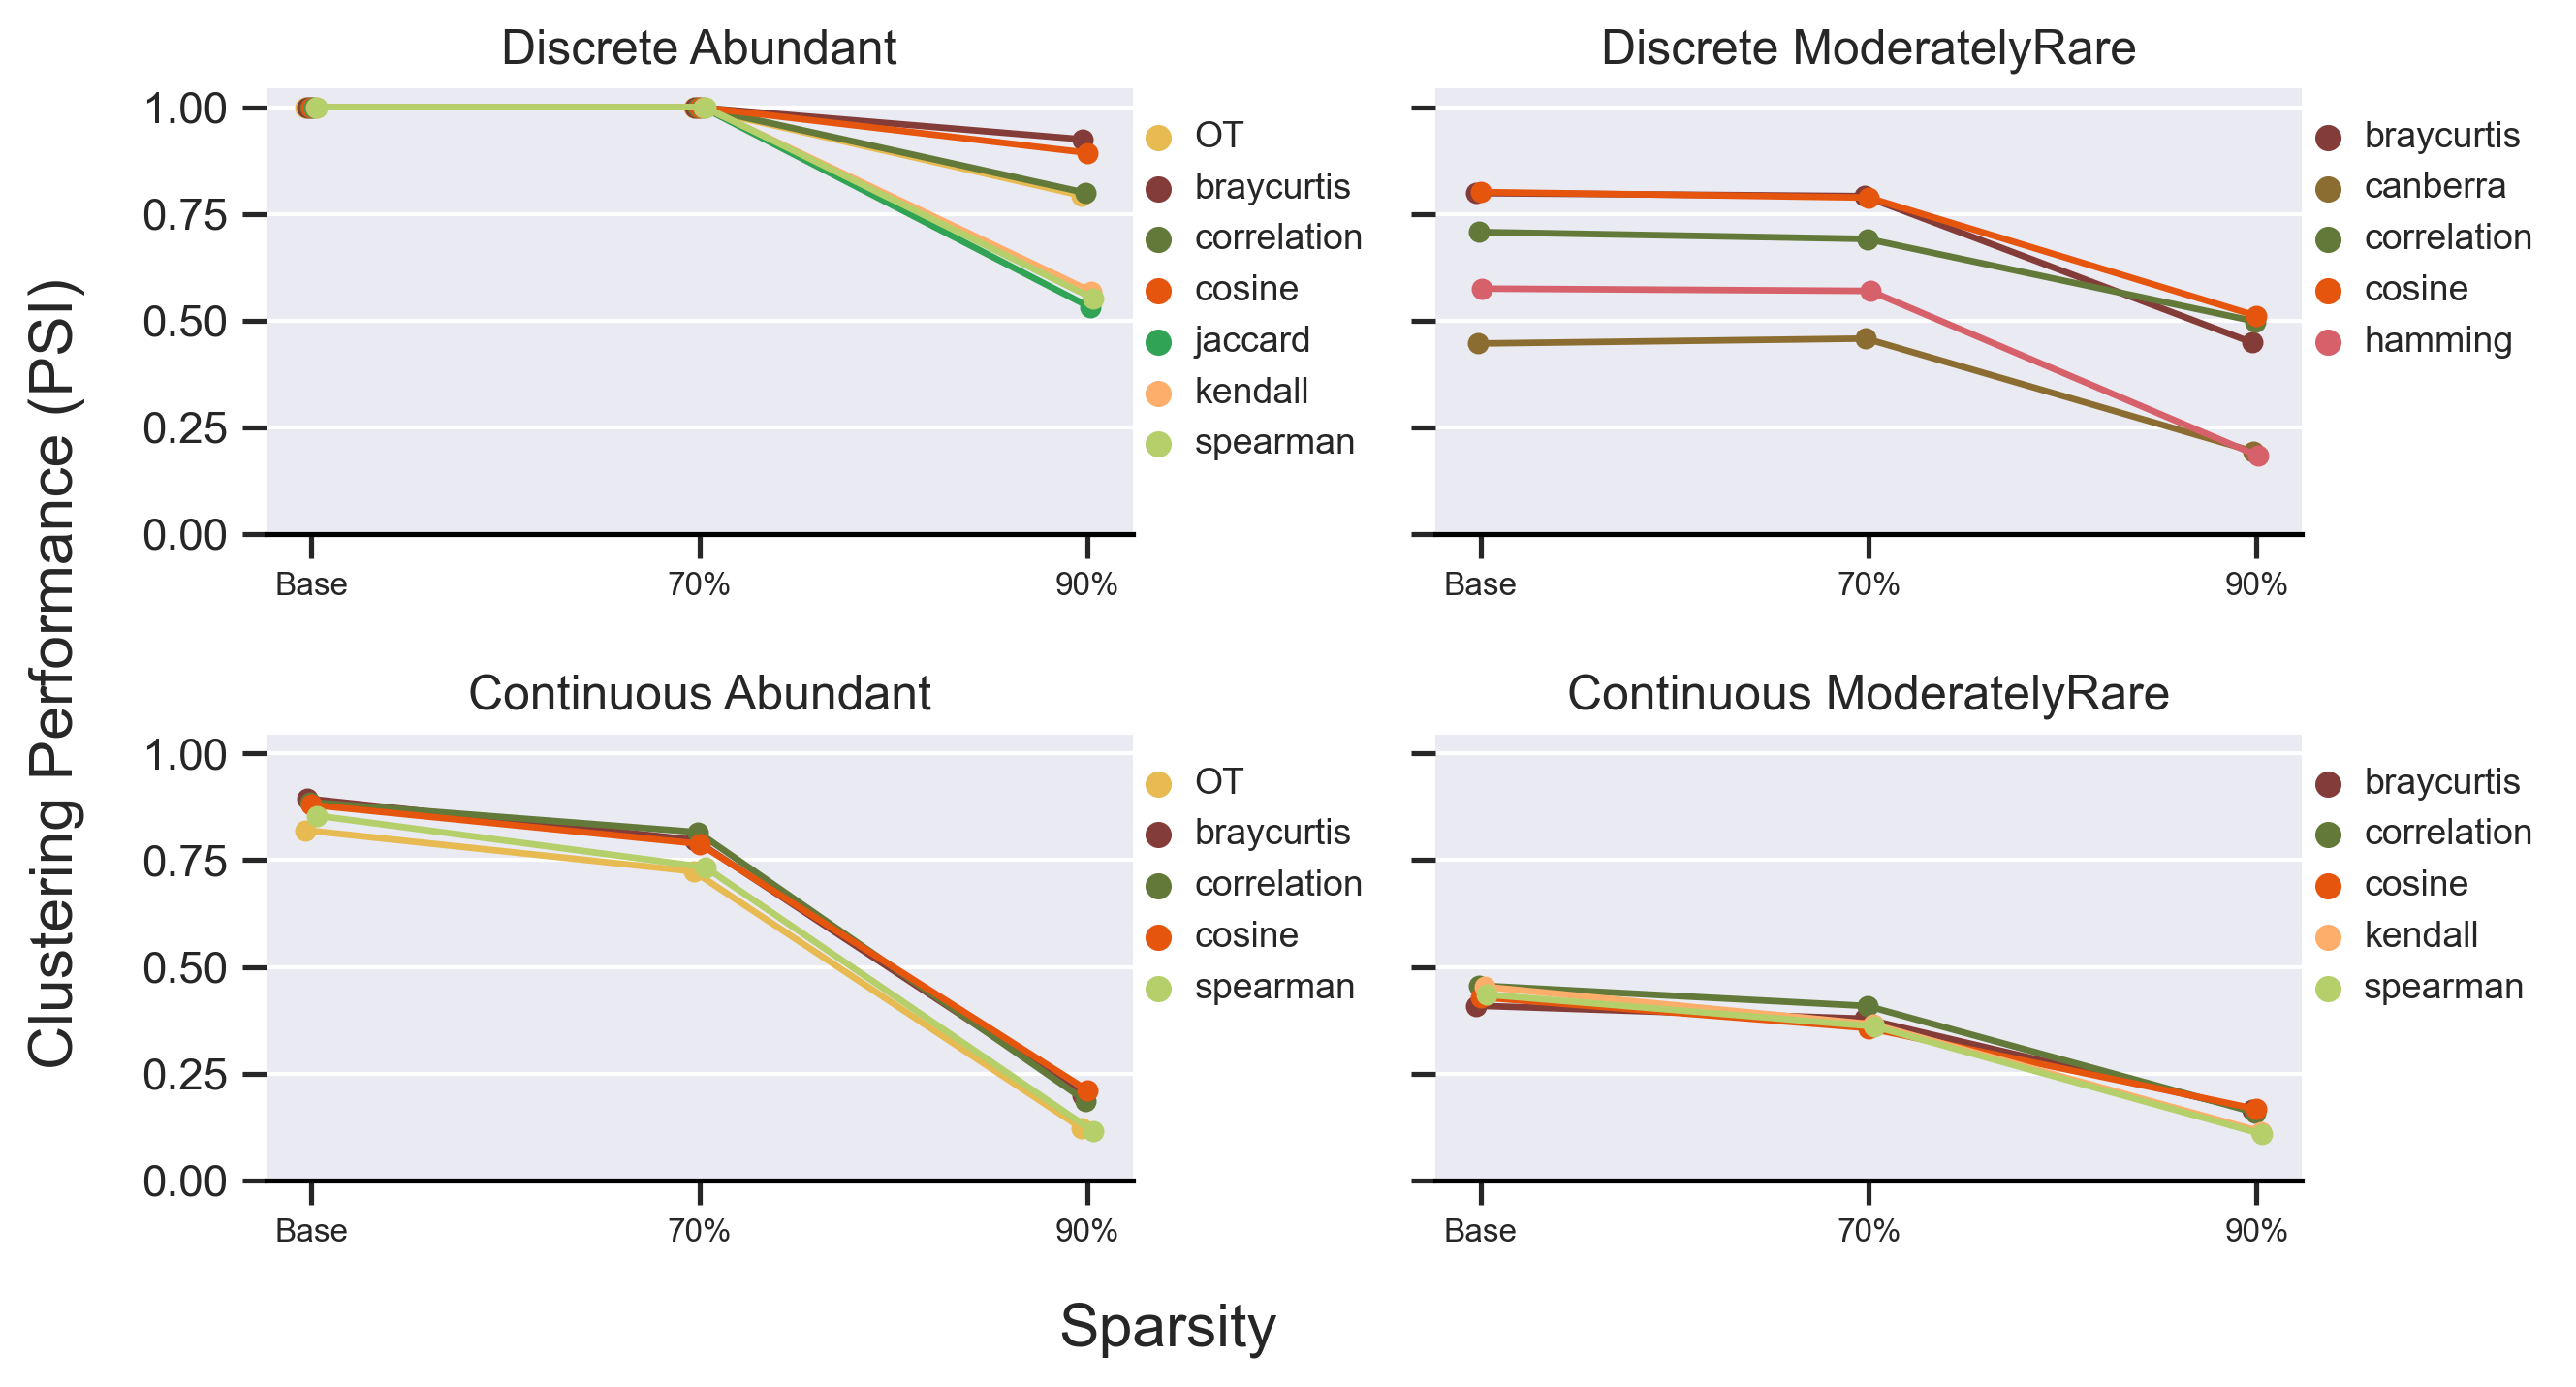

In [20]:
data = filtered_data

g = sns.catplot(x = "Property",                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete ModeratelyRare', 'Continuous Abundant', 'Continuous ModeratelyRare'],
                col_wrap = 2,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base','70%','90%'],
                dodge=0.03,
                aspect = 1.7,
                sharey = True,
                height = 2.4,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)

ser_vals = pd.Series(data['Metric'].sort_values().unique())
for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()
    
    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()
    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(), loc=2,
                    bbox_to_anchor=(0.95, 1),prop={'size': 9}, markerscale=1.3,
                    facecolor='white',handletextpad=0,frameon=False)
        
g.fig.subplots_adjust(left=0.12,wspace=0.35,hspace=0.45)
g.set(ylim=(0, None))

g.set_ylabels('')
g.set_xlabels('')
g.set_xticklabels(fontsize=8)
g.set_titles(template='{col_name}')

g.fig.supxlabel('Sparsity',fontsize=15)
g.fig.supylabel('Clustering Performance (PSI)', fontsize=15)

if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup9.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_Sup9.png',  bbox_inches = 'tight', dpi=300)

# Supplementary Figure 10

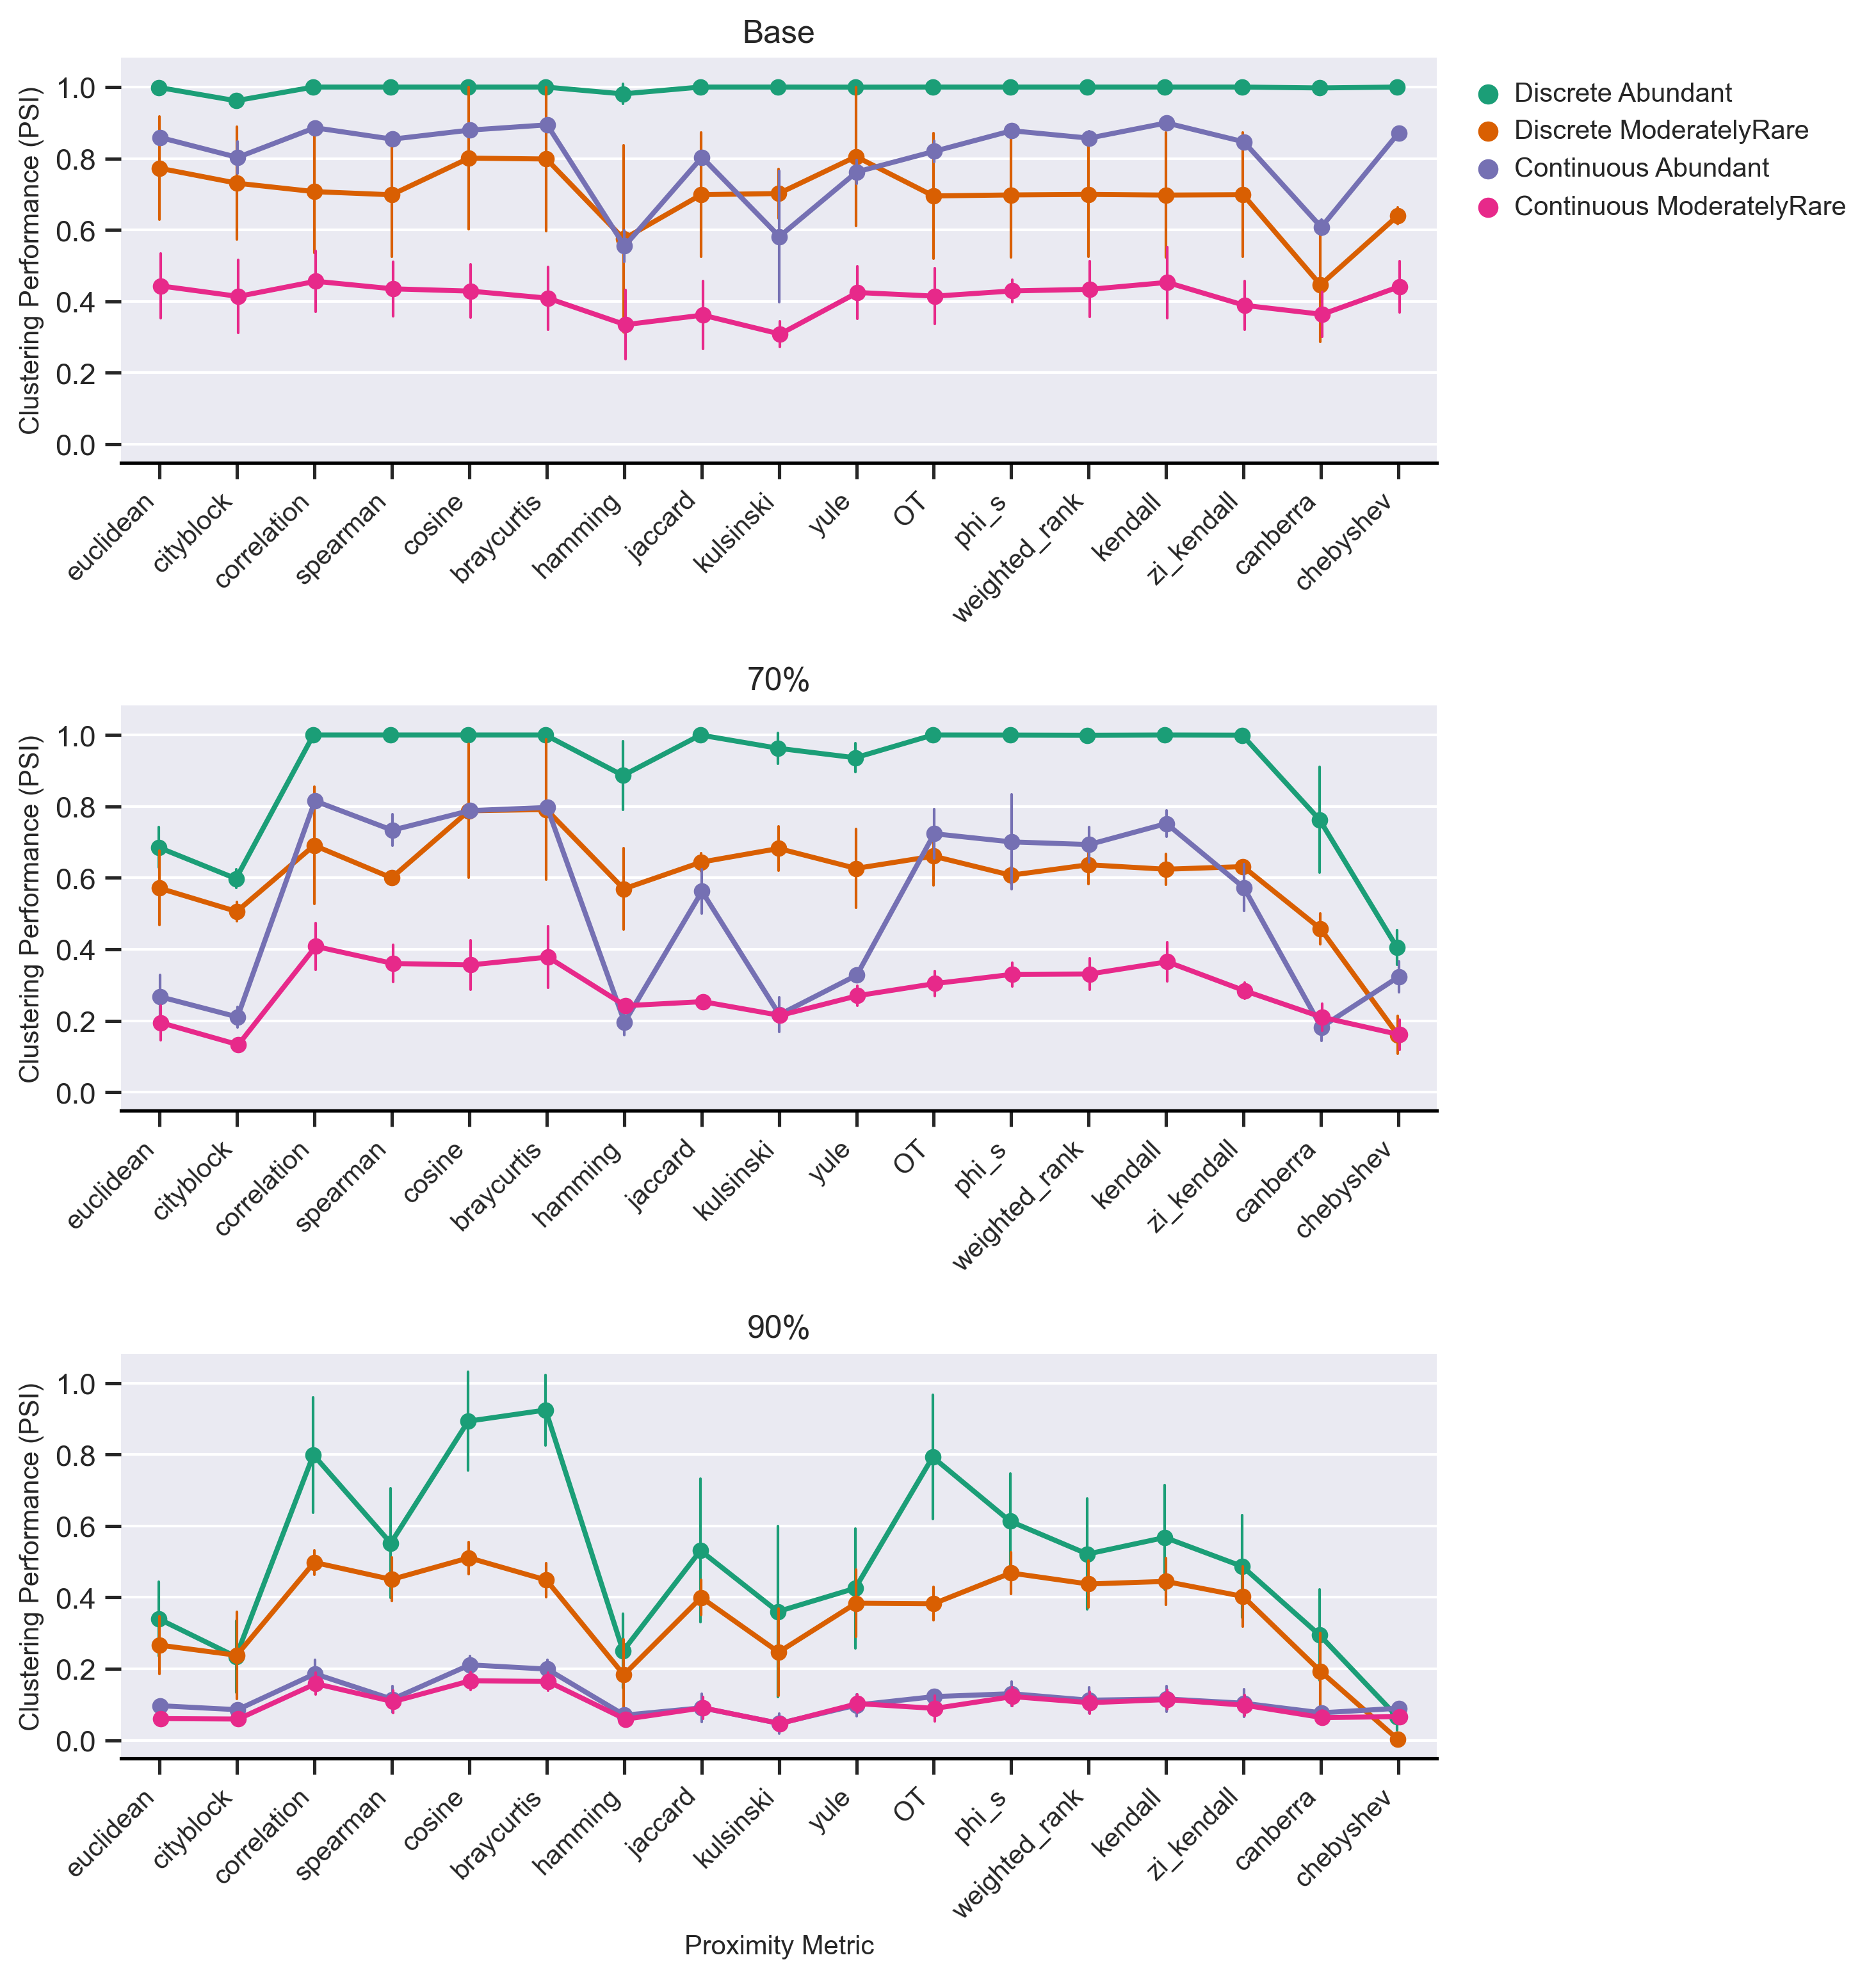

In [21]:
data = vis_df

g = sns.catplot(x = "Metric",                  
            y = 'Performance', 
            data = data,
            hue = 'Condition',
            col = 'Property',
            col_order = ['Base','70%','90%'],
            col_wrap = 1,
            palette = colour_pal,
            s=2,
            kind='point',
            join=True,
            order = all_metrics,
            dodge=0.03,
            aspect = 2.4,
            sharey = True,
            sharex = False,
            height = 3.3,
            scale = 0.7,
            ci='sd',
            errwidth = 1,
            legend_out = False).despine(left=True)

g.fig.subplots_adjust(hspace=0.6)
g.add_legend(loc=2,bbox_to_anchor=(1,1),prop={'size': 10}, markerscale=1.3,
                    facecolor='white',handletextpad=0,frameon=False)

g.set_xlabels('Proximity Metric', fontsize=10)
g.set_xticklabels(fontsize=10,rotation=45, ha='right')
g.set_ylabels('Clustering Performance (PSI)',fontsize=10)
g.set_titles(template='{col_name}')

if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup10.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_Sup10.png',  bbox_inches = 'tight', dpi=300)